# Retrofitting

## Data collection

- Download the data set called "cmu" from:
https://www.amazon.com/clouddrive/share/kfl0TTPDkXuFqTZ17WJSnhXT0q6fGkTlOTOLZ9VVPNu/folder/jRda2ADlTYy9XhWB9RUNng?_encoding=UTF8&*Version*=1&*entries*=0&mgh=1
- Put the zip file into the same directory of this notebook.
- Unzip the file. A folder "cmu" will be created.
- Into the new folder, unzip the gz files (training, development and test set).


## Display settings

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 99%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Some useful functions

In [2]:
import re
import pickle

def file2str(pathfile, coding='utf-8'):
    '''
    input: (path to) file
    output: file as string
    '''
    with open(pathfile, 'r', encoding=coding) as input_file:
        out = input_file.read()
    return out

def tsv2matrix(pathfile, filenc='utf-8', elemtype='str'):
    '''
    input: tsv file
    output: list of lists 
    '''
    str_file = file2str(pathfile, coding=filenc)
    str_file = re.sub("\n+$", '', str_file) # removing newline(s) at the end of the file
    if   elemtype == 'int':   out = [[int(elem)   for elem in row.split("\t")] for row in str_file.split("\n")]
    elif elemtype == 'float': out = [[float(elem) for elem in row.split("\t")] for row in str_file.split("\n")]
    else:                     out = [[str(elem)   for elem in row.split("\t")] for row in str_file.split("\n")]
    return out

def writebin(data: object, f_out: object) -> object:
    out = open(f_out, "wb")
    pickle.dump(data, out)
    out.close()
    return 1


def readbin(f_in):
    inp = open(f_in, "rb")
    out = pickle.load(inp)
    inp.close()
    return out


## Loading the data sets

In [3]:
tst = tsv2matrix('cmu/user_info.test',  filenc='latin-1', elemtype=str)
dev = tsv2matrix('cmu/user_info.dev',   filenc='latin-1', elemtype=str)
trn = tsv2matrix('cmu/user_info.train', filenc='latin-1', elemtype=str)
whole = tst + dev + trn
print("len tst:  ", len(tst))
print("len dev:  ", len(dev))
print("len trn:  ", len(trn))
print("len whole:", len(whole))
print()
for elem in trn[0]: print(elem[:300]) # four fields: user_id, lat, lon, text

len tst:   1895
len dev:   1895
len trn:   5685
len whole: 9475

USER_79321756
47.528139
-122.197916
RT @USER_2ff4faca: IF SHE DO IT 1 MORE TIME......IMA KNOCK HER DAMN KOOFIE OFF.....ON MY MOMMA&gt;&gt;haha. #cutthatout ||| @USER_77a4822d @USER_2ff4faca okay:) lol. Saying ok to both of yall about to different things!:* ||| RT @USER_5d4d777a: YOURE A FAG FOR GETTING IN THE MIDDLE OF THIS @USER_ab05


## Extracting coordinates and texts

In [4]:
decimals = 2
texts      = [row[3] for row in whole]
coords     = [(round(float(row[1]), decimals), round(float(row[2]), decimals)) for row in whole]
set_coords = set(coords)
print("len texts:    ", len(texts))
print("len coords:   ", len(coords))
print("len coord_set:", len(set_coords))
print("coords:", coords[:3])

len texts:     9475
len coords:    9475
len coord_set: 6721
coords: [(41.9, -87.66), (40.81, -73.95), (39.67, -79.85)]


## Clustering the coordinates
__Warning__: with big data sets, this function might take long time!
You might consider a *for* loop rather than the *while*.

In [5]:
# from collections import defaultdict
# from scipy import spatial
# from copy import deepcopy
# import numpy as np
# import time, sys

# def distance(p0, p1):
#     return np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

# def clustering(coordinates, max_distance):
#     point2instances = defaultdict(set)
#     for i, latlon in enumerate(coordinates): point2instances[latlon].add(i)
    
#     epoch = 0
#     nr_clusters_begin = -1
#     nr_clusters_end = -2
#     points = list(point2instances.keys())
#     while nr_clusters_begin != nr_clusters_end:
#         epoch += 1
#         print("epoch",  epoch)
#         tree = spatial.KDTree(points)
#         clusters_1 = tree.query_ball_tree(tree, max_distance)
#         nr_clusters_begin = len(clusters_1)
#         print("nr clusters:", len(clusters_1))
        
#         # removing duplicates:
#         clusters_2 = set(tuple(cluster) for cluster in clusters_1)
#         print("removing duplicates:\nnr clusters:", len(clusters_2))
        
#         # removing subsets of greater sets:
#         print("removing subsets of greater sets:")
#         cluster_3 = deepcopy(clusters_2)
#         for i, tup_out in enumerate(clusters_2):
#             if (i+1) % 1000 == 0: print('.....', i+1)
#             for tup_in in clusters_2:
#                 if tup_out != tup_in and set(tup_out).issubset(set(tup_in)):
#                     cluster_3.remove(tup_out)
#                     break
#         print("nr clusters:", len(cluster_3))
    
#         print("calculating custers centroid")
#         ipoint2icluster2dist = defaultdict(dict)
#         icluster2centroid = dict()
#         for icluster, cluster in enumerate(cluster_3):
#             lats = [points[ipoint][0] for ipoint in cluster]
#             lons = [points[ipoint][1] for ipoint in cluster]
#             centroid = (np.mean(lats), np.mean(lons))
#             icluster2centroid[icluster] = centroid
#             for ipoint in cluster:
#                 point = points[ipoint]
#                 dist = distance(point, centroid)
#                 ipoint2icluster2dist[ipoint][icluster] = dist
    
#         print("assigning points to the closest cluster")
#         # {point_index: {cluster_index: distance_point_centroid}} -> {point_index: closest_cluster_index}
#         ipoint2icluster = {ipoint: min(ipoint2icluster2dist[ipoint], key=ipoint2icluster2dist[ipoint].get) for ipoint in ipoint2icluster2dist}
#         # {point_index: closest_cluster_index} -> {cluster_index: {point_index}}
#         icluster2ipoints = defaultdict(set)
#         for ipoint in ipoint2icluster: icluster2ipoints[ipoint2icluster[ipoint]].add(ipoint)
#         # {cluster_index: {point_index}} -> {centroid: {point}}
#         centroid2points = defaultdict(set)
#         for icluster in icluster2ipoints: centroid2points[icluster2centroid[icluster]] = set(points[ipoint] for ipoint in icluster2ipoints[icluster])
#         # {centroid: {point}} -> {centroid: {instance}}
#         centroid2instances = defaultdict(set)
#         for centroid in centroid2points: 
#             for point in centroid2points[centroid]:
#                 centroid2instances[centroid].update(point2instances[point])
#         # updating variables
#         point2instances = centroid2instances
#         points = list(point2instances.keys())
#         nr_clusters_end = len(point2instances)
#         print("nr clusters:", len(point2instances), "\n")
     
# #     print('-----')
# #     nrinst = 0
# #     for i, point in enumerate(point2instances): 
# #         nrinst += len(point2instances[point])
# #         print(point, len(point2instances[point]))
# #     print(len(point2instances), nrinst)
#     return point2instances

# max_dist = 1
# point2insts = clustering(coords, max_dist)
# writebin(point2insts, 'point2insts.bin')

epoch 1
nr clusters: 6721
removing duplicates:
nr clusters: 3207
removing subsets of greater sets:
..... 1000
..... 2000
..... 3000
nr clusters: 999
calculating custers centroid
assigning points to the closest cluster
nr clusters: 739 

epoch 2
nr clusters: 739
removing duplicates:
nr clusters: 426
removing subsets of greater sets:
nr clusters: 239
calculating custers centroid
assigning points to the closest cluster
nr clusters: 237 

epoch 3
nr clusters: 237
removing duplicates:
nr clusters: 195
removing subsets of greater sets:
nr clusters: 162
calculating custers centroid
assigning points to the closest cluster
nr clusters: 161 

epoch 4
nr clusters: 161
removing duplicates:
nr clusters: 155
removing subsets of greater sets:
nr clusters: 142
calculating custers centroid
assigning points to the closest cluster
nr clusters: 142 

epoch 5
nr clusters: 142
removing duplicates:
nr clusters: 138
removing subsets of greater sets:
nr clusters: 138
calculating custers centroid
assigning poin

1

In [ ]:
point2insts = readbin('point2insts.bin')

## Defining Y

In [6]:
# from sklearn.preprocessing import OneHotEncoder
# # {point: {instance}} -> {instance: point}
# inst2point = {inst: point for point in point2insts for inst in point2insts[point]}
# # {instance: point} -> [rounded_point]
# Y = [(round(inst2point[inst][0], decimals),  round(inst2point[inst][1], decimals)) for inst in range(len(coords))]
# nr_labels = len(set(Y))
# print("len Y:", len(Y))
# print("nr labels:", len(set(Y)))
# print("\ntransformation header:")
# for i in range(5):
#     print("Original coordinates: {}\tlabel: {}".format(coords[i], Y[i]))

# # [rounded_point] -> [integer]
# label2int = {label: index for index, label in enumerate(set(Y))}
# Y_int = [label2int[label] for label in Y]
    
# def hotencode(labels):
#     labels = np.reshape(labels, (len(labels), 1)) # row to col
#     hotencoder = OneHotEncoder(categories='auto')
# #     hotencoder = OneHotEncoder()
#     onehot = hotencoder.fit_transform(labels)
#     return onehot

# # [integer] -> [[one_hot]]
# Y_hot = hotencode(Y_int)
# print("\none hot header:")
# Y_hot.toarray()[:2], Y_int[:2]
# writebin(Y_hot, 'Y_hot.bin')

len Y: 9475
nr labels: 138

transformation header:
Original coordinates: (41.9, -87.66)	label: (42.21, -88.0)
Original coordinates: (40.81, -73.95)	label: (40.37, -74.59)
Original coordinates: (39.67, -79.85)	label: (40.7, -80.38)
Original coordinates: (40.63, -73.93)	label: (40.37, -74.59)
Original coordinates: (26.24, -80.16)	label: (26.56, -80.26)

one hot header:


1

In [ ]:
Y_hot = readbin('Y_hot.bin')

## Text preprocessing
Converting each text (string) to a list of lemmas

In [7]:
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
# stop_words = stop_words.union(('ain', 'don', 'dont', 've', 'll', 'got', 'im', 'like', 'rt', 'lt'))
# empty = 0
# wordtexts = list()
# #no_letters_count = 0
# for i, text in enumerate(texts):
#     text = text.lower()  # to lower case
#     text = re.sub("\|\|\|", '', text)  # removing tweets separation
#     text = re.sub("[\"\{\}\[\]\,\$\%\^\&\*\_\<\>\/\:\=\+\'\u201C\u201D]+", '', text) # removing useless characters 
#     text = re.sub("(http)([a-zA-Z0-9\.\,\;\:\?\!\(\)\-])*", '', text)  # removing urls
#     text = re.sub("[0-9]+", '', text)  # numbers to 0
#     text = re.sub("([\.\;\:\?\!\(\)\-]{2,})", r' \1 ', text) # isolating punctuation blocks >=2
#     text = re.sub("[\.\;\:\?\!\(\)\-$]{1}", ' ', text) # removing final punctuation marks
#     text = re.sub(" [a-z0-9\@\#\.\;\:\?\!\(\)\-]{1} ", ' ', text)  # removing single signs
#     text = re.sub("[ \t\r\n]+", ' ', text)  # spaces to single space
#     text = re.sub("^ ", "", text)  # get rid of the initial space
#     text = re.sub(" $", "", text)  # get rid of the final space
#     words = text.split(' ')
#     nltk_lemmas = [lemmatizer.lemmatize(w, pos='v') for w in words if w not in stop_words]
#     if not nltk_lemmas:
#         empty += 1
#         print(i, "empty", text[:50])
#     wordtexts.append(nltk_lemmas)
# writebin(wordtexts, 'wordtexts.bin')

1

In [ ]:
wordtexts = readbin('wordtexts.bin')

Counting frequencies and defining the vocabulary

In [8]:
# from collections import Counter
# minfreq = 5
# freq = Counter([w for row in wordtexts for w in row])
# vocabulary = {word for word in freq if freq[word] >= minfreq}
# sel_wordtexts = [[word for word in row if word in vocabulary] for row in wordtexts]
# writebin(sel_wordtexts, 'sel_wordtexts.bin')
# print("vocabulary size:", len(vocabulary))
# freq.most_common(5)

vocabulary size: 25591


[('lol', 62184),
 ('go', 23644),
 ('get', 22795),
 ('good', 14732),
 ('lmao', 13405)]

In [ ]:
sel_wordtexts = readbin('sel_wordtexts.bin')

## Word2vec

In [9]:
# from gensim.models import Word2Vec
# model = Word2Vec(sel_wordtexts,
#                 size      = 128,   # embedding size
#                 window    = 5,     # word window around target
#                 sg        = 1,     # 0 = CBOW, 1 = skipgram
#                 alpha     = .05,   # initial learning rate
#                 min_alpha = .01,   # alpha drop to min_alpha as training progresses
#                 iter      = 50,    # number of iterations
#                 min_count = 1,     # min frequency for counting words
#                 seed      = 7,     # seed for random num generation
#                 negative  = 10,    # If > 0, negative sampling will be used, the int for negative specifies how many 'noise words' should be drawn (usually between 5-20).
#                 sample    = .0001, # threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5)
#                 null_word = 0)     # if 1, it appends the null word to the end of the vocabulary
# writebin(model, 'model50.bin')


1

In [ ]:
model = readbin('model50.bin')

In [10]:
# embmatrix = model.wv.vectors
# word2index = {word: index for index, word in enumerate(model.wv.index2word)}
# writebin(embmatrix, 'embmatrix.bin')
# writebin(word2index, 'word2index.bin')

1

In [ ]:
embmatrix = readbin('embmatrix.bin')
word2index = readbin('word2index.bin')

## Word geographical distribution
Building a sparse matrix word for labels

In [11]:
# from scipy.sparse import lil_matrix
# X_tst = sel_wordtexts[:len(tst)]
# X_dev = sel_wordtexts[len(tst):len(dev)]
# X_trn = sel_wordtexts[len(tst) + len(dev):]
# distribution  = lil_matrix((len(vocabulary), nr_labels), dtype=int)

# for irow in range(len(X_trn)):
#     for word in set(X_trn[irow]):
#         distribution[word2index[word], Y_int[irow]] += 1

# mincount = 10
# distribution[distribution < mincount] = 0
# writebin(distribution, 'distribution.bin')
# distribution.shape

/home/fornaciari/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


(25591, 138)

In [ ]:
distribution = readbin('distribution.bin')

## Word neighbors
Linking the words to other words found in the same areas.
Steps:
- Creating a dictionary mapping each word_index to the areas (label_index) where the word is found;
- Creating a dictionary mapping each area (label_index) to the word_indices of the words found in that area;
- Creating a dictionary mapping each word to other words appearing in the same places.

This might mean to map each word to a whole vocabulary: filtering is necessary!


In [12]:
# # {iword: {ilabel}}
# iword2ilabels = {iword: set(np.where(distribution.toarray()[iword] > 0)[0]) for iword in range(distribution.shape[0])}
# # {ilabel: {iword}}
# distributionT = np.transpose(distribution)
# ilabel2iwords = {ilabel: set(np.where(distributionT.toarray()[ilabel] > 0)[0]) for ilabel in range(distributionT.shape[0])}
# writebin(iword2ilabels, 'iword2ilabels.bin')
# writebin(ilabel2iwords, 'ilabel2iwords.bin')

1

In [13]:
iword2ilabels = readbin('iword2ilabels.bin')
ilabel2iwords = readbin('ilabel2iwords.bin')

In [14]:
# # iword2iwords: alias neighbors
# iword2iwords = defaultdict(set)
# for iword in range(distribution.shape[0]):
#     for ilabel in iword2ilabels[iword]:
#         iword2iwords[iword].update(ilabel2iwords[ilabel])
#     iword2iwords[iword] = list(iword2iwords[iword]) # retrofitting needs a list
# writebin(iword2iwords, 'iword2iwords.bin')

1

In [15]:
iword2iwords = readbin('iword2iwords.bin')

## Retrofitting

In [17]:
def retrofit(vectors, neighbors, normalize=False, num_iters=10, alfa=0):
    """
    vectors: N by D numpy array
    neighbors: {int: [int]}
    """
    N, D = vectors.shape

    new_vectors = deepcopy(vectors)

    if normalize:
        for c in range(N):
            vectors[c] /= np.sqrt((vectors[c] ** 2).sum() + 1e-6)

    # run retrofitting
    print("retrofitting", file=sys.stderr)

    for it in range(num_iters):
        print("\t{}:".format(it + 1), end=' ', file=sys.stderr)
        # loop through every vector
        for c in range(N):
            if c > 0:
                if c % 1000 == 0:
                    print(c, end='', file=sys.stderr)
                elif c % 100 == 0:
                    print(".", end='', file=sys.stderr)
            instance_neighbours = neighbors.get(c)
            if instance_neighbours is None:
                continue
            num_neighbours = len(instance_neighbours)
            # no neighbours, pass - use data estimate
            if num_neighbours == 0:
                continue

            beta = 1 - alfa

            # the weight of the original data estimate is 
            # the number of neighbours, 
            # plus the sum of all neighboring vectors, 
            # normalized by twice the number of neighbors
            if alfa == 0:
                new_vectors[c] = ((num_neighbours * vectors[c]) + new_vectors[instance_neighbours].sum(axis=0)) / (
                            2 * num_neighbours)
            else:
                # new_vectors[c] = ((beta * (num_neighbours * vectors[c])) + (alfa * new_vectors[instance_neighbours].sum(axis=0))) / (2 * num_neighbours)
                new_vectors[c] = ((beta * (num_neighbours * vectors[c])) + (
                            alfa * new_vectors[instance_neighbours].sum(axis=0))) / (
                                             beta * num_neighbours + alfa * num_neighbours)

        print('', file=sys.stderr)
    return new_vectors


In [49]:
alpha = .99
iters = 10
retromatrix = retrofit(embmatrix, iword2iwords, num_iters=iters, alfa=alpha)
writebin(retromatrix, 'retromatrix10a099.bin')
retromatrix.shape, embmatrix.shape

retrofitting
	1: .........1000.........2000.........3000.........4000.........5000.........6000.........7000.........8000.........9000.........10000.........11000.........12000.........13000.........14000.........15000.........16000.........17000.........18000.........19000.........20000.........21000.........22000.........23000.........24000.........25000.....
	2: .........1000.........2000.........3000.........4000.........5000.........6000.........7000.........8000.........9000.........10000.........11000.........12000.........13000.........14000.........15000.........16000.........17000.........18000.........19000.........20000.........21000.........22000.........23000.........24000.........25000.....
	3: .........1000.........2000.........3000.........4000.........5000.........6000.........7000.........8000.........9000.........10000.........11000.........12000.........13000.........14000.........15000.........16000.........17000.........18000.........19000.........20000.........2

((25591, 128), (25591, 128))

In [50]:
retromatrix = readbin('retromatrix10a099.bin')

,x,y
lol,-0.558463,-0.249495
go,0.492196,-0.038881
get,0.076164,0.134390
good,0.525528,0.907114
lmao,-0.815198,-0.265117


(10, 2)

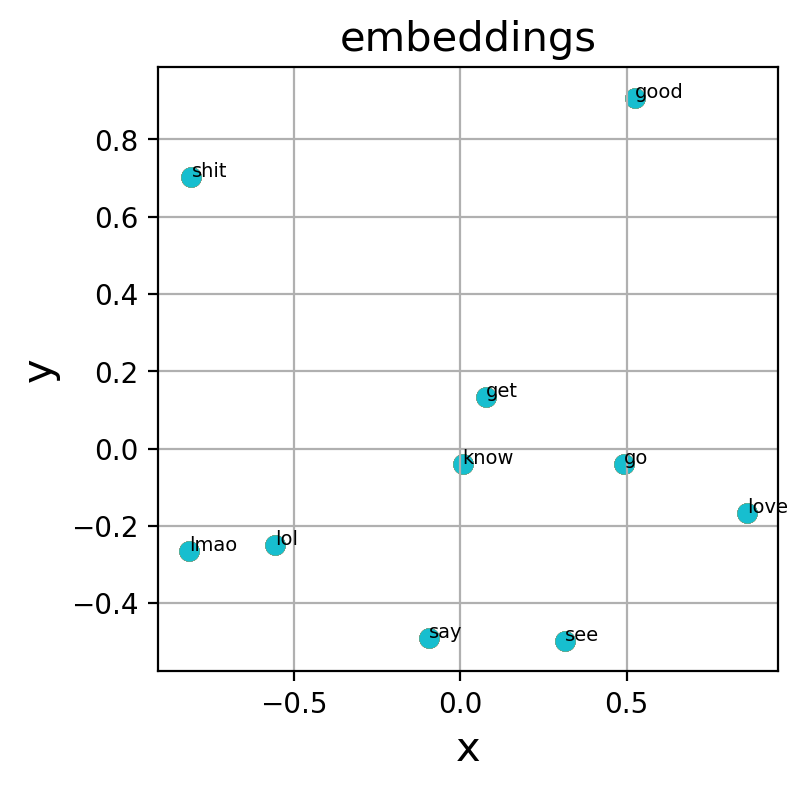

,x,y
lol,-0.005584,-0.002494
go,0.004922,-0.000388
get,0.000762,0.001345
good,0.005255,0.009072
lmao,-0.008152,-0.002651


(10, 2)

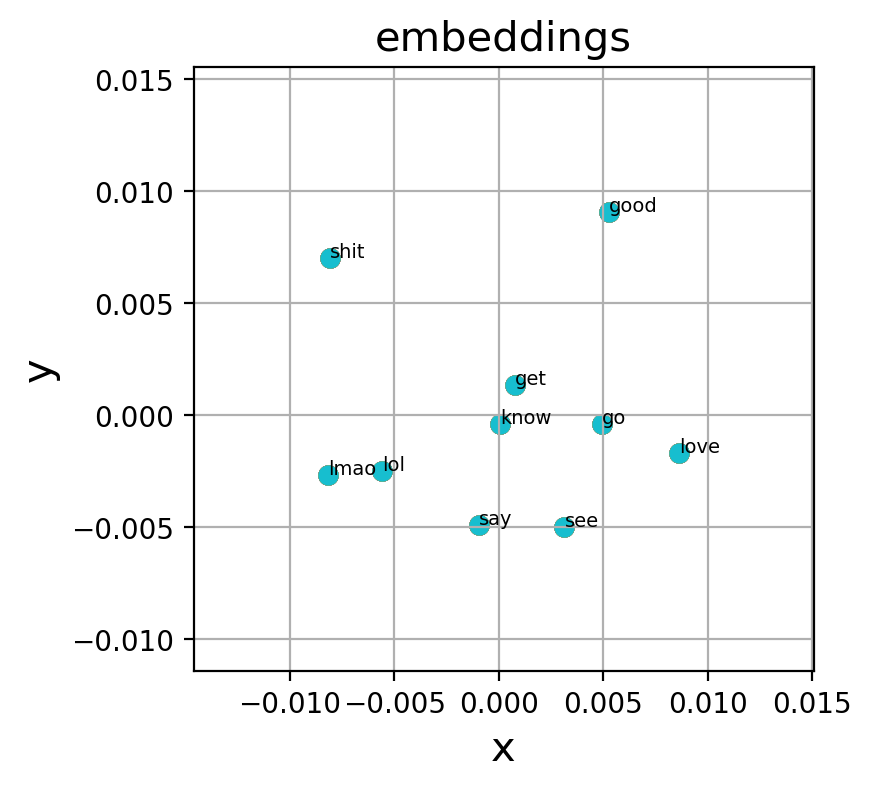

1

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def go_pca(embs, words):
    cols = ['x','y']
    pca = PCA(n_components=2)
    pca.fit(embs)
    pca_points = pca.transform(embs)
    df = pd.DataFrame(pca_points, index=words, columns=cols)
    
    display(df.head())
    display(df.shape)

    fig = plt.figure(figsize=(4, 4), dpi=200)
    point_size = 40
    text_point_size = 7
    hor_align = 'left'
    ver_align = 'top'
    
    ax = fig.gca()
    ax.set_title('embeddings', fontsize = 15)
    ax.set_xlabel('x', fontsize = 15)
    ax.set_ylabel('y', fontsize = 15)
    for i, word in enumerate(words):
        ax.scatter(df['x'], df['y'], label=words, s=point_size)
        ax.text(df['x'][i], df['y'][i], s =word, fontsize=text_point_size)
    ax.grid()
#     plt.savefig('pca.pdf')
    plt.show()
    return 1    
    
go_pca(embmatrix[iword2iwords[0][:10]], np.array(model.wv.index2word)[iword2iwords[0][:10]])  
go_pca(retromatrix[iword2iwords[0][:10]], np.array(model.wv.index2word)[iword2iwords[0][:10]])  